# Explore Discharge Predictions (CamelsGB)

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = Path(".").absolute().parents[0]
import sys

if sys.path[0] != base_dir.as_posix():
    sys.path = [base_dir.as_posix()] + sys.path

In [2]:
from spatio_temporal.config import Config
from spatio_temporal.training.trainer import Trainer
from spatio_temporal.training.tester import Tester
from tests.utils import (
    create_linear_ds,
    _test_sklearn_model,
    download_test_jena_data,
    load_test_jena_data_as_dataset
)
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_losses

# Load in config file and predictions

In [3]:
ds = xr.open_dataset(base_dir / "data/ALL_dynamic_ds.nc")
ds

<xarray.Dataset>
Dimensions:         (station_id: 671, time: 16436)
Coordinates:
  * station_id      (station_id) int64 1001 2001 2002 ... 102001 106001 107001
  * time            (time) datetime64[ns] 1970-10-01 1970-10-02 ... 2015-09-30
Data variables:
    precipitation   (time, station_id) float64 ...
    pet             (time, station_id) float64 ...
    temperature     (time, station_id) float64 ...
    discharge_spec  (time, station_id) float64 ...
    discharge_vol   (time, station_id) float64 ...
    peti            (time, station_id) float64 ...
    humidity        (time, station_id) float64 ...
    shortwave_rad   (time, station_id) float64 ...
    longwave_rad    (time, station_id) float64 ...
    windspeed       (time, station_id) float64 ...

In [4]:
run_dir = base_dir / "runs/runoff_aws/"
cfg = Config(run_dir / "config.yml")
cfg

{'autoregressive': False,
 'batch_size': 256,
 'clip_gradient_norm': None,
 'data_dir': PosixPath('data'),
 'device': 'cuda:0',
 'experiment_name': 'runoff',
 'forecast_variables': None,
 'hidden_size': 64,
 'horizon': 0,
 'input_variables': ['temperature', 'precipitation'],
 'learning_rate': 0.01,
 'loss': 'MSE',
 'n_epochs': 30,
 'num_workers': 8,
 'optimizer': 'Adam',
 'pixel_dims': ['station_id'],
 'run_dir': PosixPath('/home/tommy/spatio_temporal/runs/runoff_2302_183834'),
 'scheduler': None,
 'seed': 1234,
 'seq_length': 356,
 'static_inputs': None,
 'target_variable': 'discharge_spec',
 'test_end_date': Timestamp('2008-12-31 00:00:00'),
 'test_start_date': Timestamp('1998-01-01 00:00:00'),
 'time_str': 'time',
 'train_end_date': Timestamp('1997-12-31 00:00:00'),
 'train_start_date': Timestamp('1988-01-01 00:00:00'),
 'validate_every_n': 1,
 'validation_end_date': Timestamp('1987-12-31 00:00:00'),
 'validation_start_date': Timestamp('1985-01-01 00:00:00')}

In [5]:
xr_path = sorted(list(run_dir.glob("*.nc")))[-1]
preds = xr.open_dataset(xr_path).isel(horizon=0).drop("horizon")
preds

<xarray.Dataset>
Dimensions:  (pixel: 671, time: 3662)
Coordinates:
  * time     (time) datetime64[ns] 1998-12-22T23:59:46.966659072 ... 2008-12-...
  * pixel    (pixel) object '10002_10002' '10003_10003' ... '97002_97002'
Data variables:
    sim      (time, pixel) float32 ...
    obs      (time, pixel) float32 ...

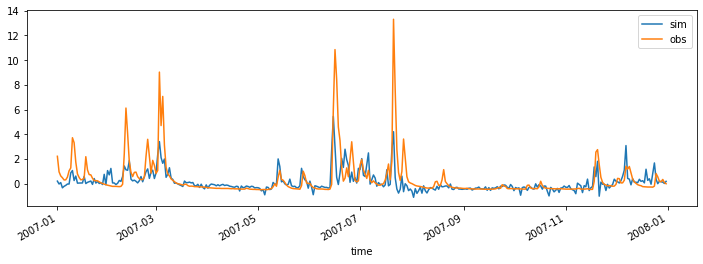

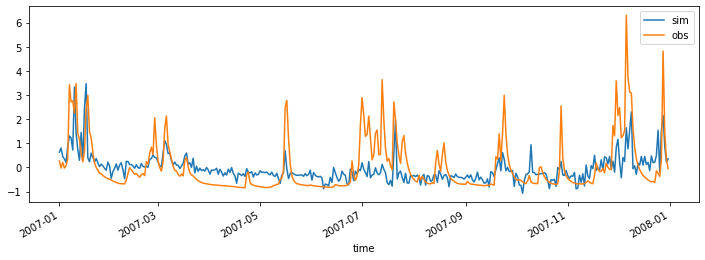

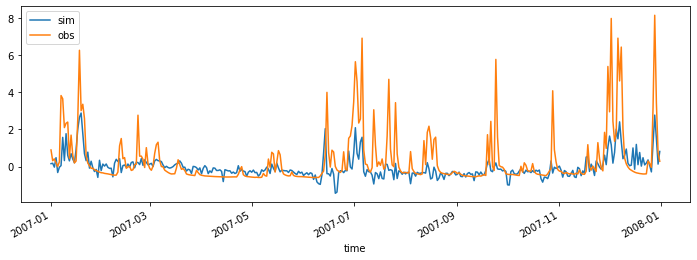

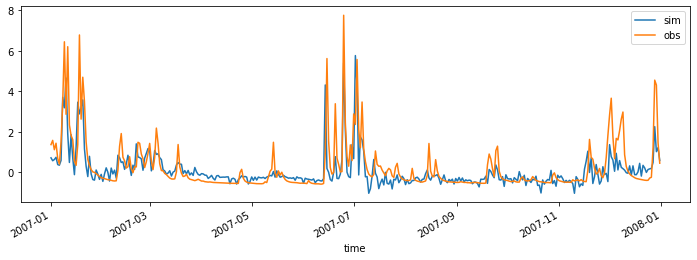

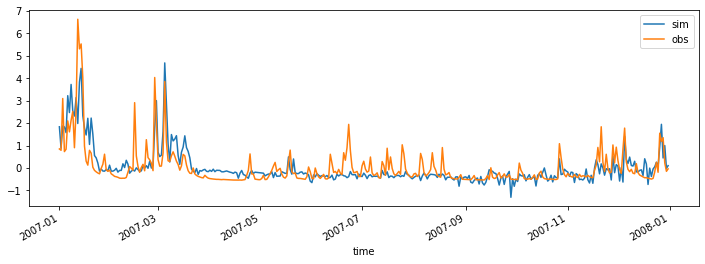

In [6]:
for i in range(5):
    f, ax = plt.subplots(figsize=(12, 4))
    pixel = np.random.choice(preds.pixel.values)
    preds.sel(time="2007", pixel=pixel).to_dataframe().plot(ax=ax)

# Test specific epoch

In [7]:
# sorted(list(run_dir.glob("*.pt")))
cfg._cfg["run_dir"] = run_dir
cfg._cfg["device"] = "cpu"
cfg._cfg["num_workers"] = 4
tester = Tester(cfg, ds)

Loading Data: 100%|██████████| 671/671 [00:06<00:00, 96.20it/s] 


In [ ]:
tester.run_test(epoch=5)

Test set Forward Pass:  15%|█▍        | 1435/9599 [07:10<40:16,  3.38it/s]